In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

import kliep

## Multivariate Gaussian

In [2]:
pre = [[1,   0.5,    0],
       [0.5,   1, -0.4],
       [0,  -0.4,    1]]
cov = np.linalg.inv(pre)
print(np.array(pre))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0. ]
 [ 0.5  1.  -0.4]
 [ 0.  -0.4  1. ]]


In [3]:
d = 3
mi = np.zeros([d, d])
cmi = np.zeros([d, d])
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i > j]):
    mi[i, j] = mi[j, i] = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), maxiter=1000)
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi_xz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_yz = kliep.mutual_information_kliep(X=X[:, j].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_xyz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), Z=X[:, mask], maxiter=1000)
    cmi[i, j] = cmi[j, i] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 3/3 [00:16<00:00,  5.63s/it]


array([[ 0.        ,  0.14392269, -0.00783641],
       [ 0.14392269,  0.        ,  0.07337808],
       [-0.00783641,  0.07337808,  0.        ]])

In [4]:
model = sklearn.covariance.GraphLasso(alpha=0.3)
model.fit(X)

GraphLasso(alpha=0.3, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

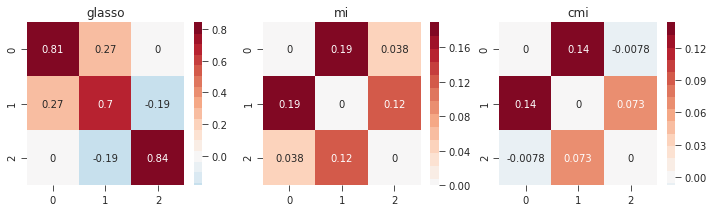

In [5]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('glasso')
axes[1].set_title('mi')
axes[2].set_title('cmi')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0, cmap=palette)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, cmap=palette)
plt.savefig('output/cmi.png', dpi=120)

## Multivariate Gaussian Mixuture

In [6]:
X1 = scipy.stats.multivariate_normal(mean=[-5,  0,  0], cov=np.eye(3)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+5,  0,  0], cov=np.eye(3)).rvs(500)
X3 = scipy.stats.multivariate_normal(mean=[ 0, 10,  0], cov=np.eye(3)).rvs(500)
X = np.vstack([X1, X2, X3])
X.shape

(1500, 3)

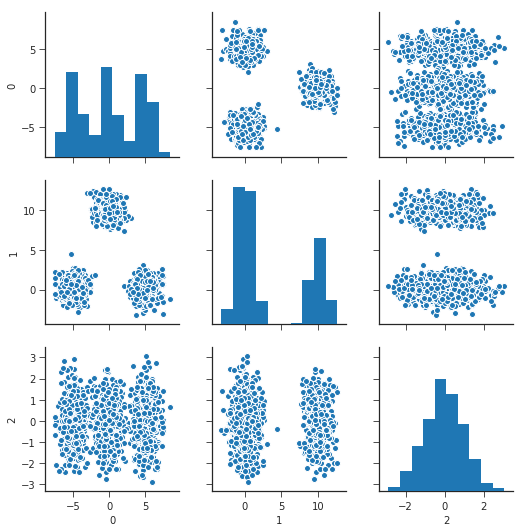

In [7]:
sns.pairplot(pd.DataFrame(X))

In [8]:
d = 3
mi = np.zeros([d, d])
cmi = np.zeros([d, d])
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i > j]):
    mi[i, j] = mi[j, i] = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), maxiter=1000)
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi_xz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_yz = kliep.mutual_information_kliep(X=X[:, j].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_xyz = kliep.mutual_information_kliep(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), Z=X[:, mask], maxiter=1000)
    cmi[i, j] = cmi[j, i] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


array([[ 0.        ,  0.59974505, -0.01211641],
       [ 0.59974505,  0.        , -0.01559272],
       [-0.01211641, -0.01559272,  0.        ]])

In [9]:
model = sklearn.covariance.GraphLasso(alpha=0.1)
model.fit(X)

GraphLasso(alpha=0.1, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

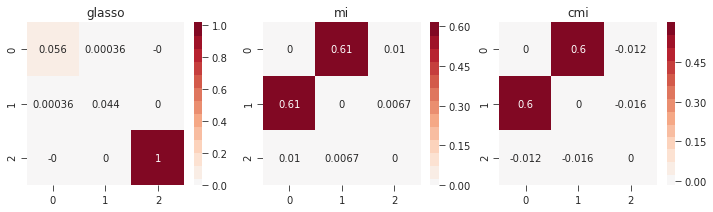

In [10]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('glasso')
axes[1].set_title('mi')
axes[2].set_title('cmi')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0, cmap=palette)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, cmap=palette)
plt.savefig('output/cmi2.png', dpi=120)